In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import string

In [41]:
class Crossbar:
    def __init__(self,crossbar_resistivestate_matrix_input=None):
        self.selector_line_literals = None
        self.selectorLineHeads = None
        self.start = None
        self.end = None
        self.pos = None
        self.crossbar_graph = None
        self.crossbar_resistivestate_matrix = self.load_crossbar(crossbar_resistivestate_matrix_input)

    def load_crossbar(self,crossbar_resistivestate_matrix_input=None):
        if(crossbar_resistivestate_matrix_input==None):
            print('Initiate the crossbar resistive states as input in class or function')
            return

        self.selector_line_literals = [0 for i in crossbar_resistivestate_matrix_input[0]]
        crossbar_resistivestate_matrix = crossbar_resistivestate_matrix_input

        # Create a directed graph
        crossbar_graph = nx.DiGraph()

        # Add edges to the graph (node connections)
        edges = []
        start = 'WL0,0'
        end = []

        selectorLineHeads = []

        # Adding word lines
        for i in range(len(crossbar_resistivestate_matrix_input)):
            for j in range(len(crossbar_resistivestate_matrix_input[0])):
                edges.append(('WL'+str(i)+','+str(j), 'WL'+str(i)+','+str(j+1),1))
        end.append('WL'+str(i)+','+str(j+1))

        # Adding selector lines and Bit lines
        for i in range(len(crossbar_resistivestate_matrix_input[0])):
            for j in range(len(crossbar_resistivestate_matrix_input)):  #wrong assignments
                edges.append(('SL'+str(i)+','+str(j), 'SL'+str(i)+','+str(j+1),1))
                edges.append(('BL'+str(i)+','+str(j), 'BL'+str(i)+','+str(j+1),1))

                # Adding transistors
                edges.append(('SL'+str(i)+','+str(j), 'Transistor'+str(i)+','+str(j),1)) #for controlling transistor based on the literal value

                edges.append(('WL'+str(j)+','+str(i), 'Transistor'+str(i)+','+str(j),1))
                edges.append(('Transistor'+str(i)+','+str(j), 'WL'+str(j)+','+str(i),1))

                edges.append(('Transistor'+str(i)+','+str(j), 'Memristor'+str(i)+','+str(j),0))  #control transistor open or close
                edges.append(('Memristor'+str(i)+','+str(j), 'Transistor'+str(i)+','+str(j),0))

                edges.append(('Memristor'+str(i)+','+str(j), 'BL'+str(i)+','+str(j),crossbar_resistivestate_matrix_input[j][i]))
                edges.append(('BL'+str(i)+','+str(j), 'Memristor'+str(i)+','+str(j),crossbar_resistivestate_matrix_input[j][i]))

                if(j==0):
                    selectorLineHeads.append('SL'+str(i)+','+str(j))

        self.selectorLineHeads = selectorLineHeads
        # self.start = start
        # self.end = end
        print("Selector Lines="+str(selectorLineHeads))

        crossbar_graph.add_edges_from([(u, v, {'capacity': cap}) for u, v, cap in edges])

        # Define node positions for visualization (optional for better graph layout)
        pos = nx.spring_layout(crossbar_graph)

        pos = {}

        # Wordlines (horizontal, from left to right, stacked vertically)
        for i in range(len(crossbar_resistivestate_matrix_input)):
            for j in range(len(crossbar_resistivestate_matrix_input[0])+1):
                pos[f'WL{i},{j}'] = (j, -i)  # Horizontally from left to right, stacked vertically

        # Selector lines (vertical, from top to bottom, stacked horizontally)
        for i in range(len(crossbar_resistivestate_matrix_input[0])):
            for j in range(len(crossbar_resistivestate_matrix_input)+1):
                pos[f'SL{i},{j}'] = (i + len(crossbar_resistivestate_matrix_input[0]) + 2, -j)  # Offset horizontally to right

        # Bitlines (vertical, from top to bottom, stacked horizontally next to selector lines)
        for i in range(len(crossbar_resistivestate_matrix_input[0])):
            for j in range(len(crossbar_resistivestate_matrix_input)+1):
                pos[f'BL{i},{j}'] = (i + len(crossbar_resistivestate_matrix_input[0]) + 5, -j)  # Offset horizontally further right

        for i in range(len(crossbar_resistivestate_matrix_input[0])):
            for j in range(len(crossbar_resistivestate_matrix_input)):
                pos[f'Transistor{i},{j}'] = (j + 0.5, -i - 0.5)  # Place transistors slightly below and to the right of their connections
                pos[f'Memristor{i},{j}'] = (j + 1, -i - 1)  # Place memristors below the transistors

        # print(pos)
        self.pos = pos

        self.crossbar_graph = crossbar_graph
        return crossbar_graph

    def setStartEndPoints(self,start,end):
        self.start = start
        self.end = end

    # Visualize the graph using Matplotlib and NetworkX
    def visualize_graph(self):
        plt.figure(figsize=(12, 8))

        G = self.crossbar_graph
        pos = self.pos

        print(pos)
        # Filter nodes that have positions defined in pos
        nodes_with_pos = {node: pos[node] for node in G.nodes if node in pos}

        # Draw the graph with only the nodes that have defined positions
        nx.draw(G, nodes_with_pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=12, font_weight='bold', arrows=True)

        # Add edge labels (capacity)
        edge_labels = {(u, v): f'{d["capacity"]}' for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        plt.show()

    def set_literals(self, literals_input=None):
        if literals_input is None:
            literals_input = [1 for _ in self.selectorLineHeads]

        # Ensure the literals match the number of selector lines
        if len(literals_input) != len(self.selectorLineHeads):
            print("Length of literals input does not match the number of selector line heads")
            return

        self.selector_line_literals = literals_input

        # Traverse the graph starting from each selector line head
        for i, selector_head in enumerate(self.selectorLineHeads):
            # BFS initialization
            queue = deque([selector_head])
            visited = set()

            while queue:
                current_node = queue.popleft()

                # Avoid revisiting nodes
                if current_node in visited:
                    continue
                visited.add(current_node)

                # Check if the current node is a Transistor
                if current_node.startswith('Transistor'):
                    transistor_index = current_node[len('Transistor'):]  # Extract the indices

                    # Update the edges to and from the Memristor
                    memristor_node = 'Memristor' + transistor_index
                    if self.crossbar_graph.has_edge(current_node, memristor_node):
                        self.crossbar_graph[current_node][memristor_node]['capacity'] = literals_input[i]
                    if self.crossbar_graph.has_edge(memristor_node, current_node):
                        self.crossbar_graph[memristor_node][current_node]['capacity'] = literals_input[i]

                # Add neighbors to the queue for BFS
                for neighbor in self.crossbar_graph.successors(current_node):
                    if neighbor not in visited and (neighbor.startswith('Transistor') or neighbor.startswith('SL')):
                        queue.append(neighbor)

        print("Connections updated in the crossbar based on the literals.")

    def evaluate_crossbar(self, literals_input=None, displayPath=False):
        if literals_input is not None:
            self.set_literals(literals_input)

        # Result array initialized to 0's, with the same length as self.end
        results = [0] * len(self.end)

        # Dictionary to store the parent of each node for path reconstruction
        parent = {}

        # Perform BFS from the start node
        queue = deque([self.start])
        visited = set()

        while queue:
            current_node = queue.popleft()

            # Avoid revisiting nodes
            if current_node in visited:
                continue
            visited.add(current_node)

            # Check if the current node is one of the endpoints
            if current_node in self.end:
                # Set the corresponding result index to 1
                index = self.end.index(current_node)
                results[index] = 1

                if displayPath:
                    # Reconstruct and print the path from the start to the current endpoint
                    path = []
                    current_node1 = current_node
                    while current_node1 is not None:
                        path.append(current_node1)
                        current_node1 = parent.get(current_node1, None)
                    path.reverse()  # Reverse the path to start from the origin
                    print(f"Path to {self.end[index]}: {' -> '.join(path)}")

            # Add all unvisited neighbors to the queue
            for neighbor in self.crossbar_graph.successors(current_node):
                if neighbor not in visited and self.crossbar_graph[current_node][neighbor]['capacity'] > 0:
                    queue.append(neighbor)
                    # Record the parent of the neighbor
                    parent[neighbor] = current_node

        return results

<h1>Boolean Expresions</h1><h2>
cout = (a0 ∧ b0) ∨ (a0 ∧ cin) ∨ (b0 ∧ cin) <br>
s0 = a0 ⊕ b0 ⊕ cin
</h2>

In [60]:
crossbar_resistivestate_matrix1 = [
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # Row 1
    [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],  # Row 2
    [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],  # Row 3
    [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],  # Row 4
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],  # Row 5
    [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],  # Row 6
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],  # Row 7
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],  # Row 8
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]   # Row 9
]

# crossbar_resistivestate_matrix1 = [
#     [1, 1, 0, 0],
#     [0, 1, 1, 1],
#     [1, 0, 1, 1],
# ]

# crossbar_resistivestate_matrix1 = [
#     [1, 0, 1],
#     [1, 1, 0],
#     [0, 1, 1],
# ]

crossbar_resistivestate_matrix1 = [
    [1, 1, 0, 0, 0, 0],  # Row 1
    [1, 0, 1, 1, 0, 0],  # Row 2
    [0, 1, 0, 0, 1, 1],  # Row 3
    [0, 0, 1, 0, 0, 0],  # Row 4
    [0, 0, 0, 1, 0, 0],  # Row 5
    [0, 0, 0, 0, 1, 0],  # Row 6
    [0, 0, 1, 1, 0, 1],  # Row 7
    [0, 0, 1, 0, 0, 0],  # Row 8
    [0, 0, 0, 1, 0, 0],  # Row 9
]

crossbar=Crossbar()
crossbar.setStartEndPoints(start = 'WL0,0', end=['WL3,6','WL4,6','WL5,6','WL7,6','WL8,6','BL5,6'])
crossbar.load_crossbar(crossbar_resistivestate_matrix1)
# a.visualize_graph()
# a & b | c
# crosbar.set_literals([0,0,1])

# s0 = a0 ⊕ b0 ⊕ cin
# [a,b,c] = [0,0,0]
# [a,b,c] = [1,0,0]
# [a,b,c] = [0,1,0]
# [a,b,c] = [1,0,0]
# [a,b,c] = [0,0,1]
# [a,b,c] = [0,1,1]
# [a,b,c] = [1,0,1]
[a,b,c] = [1,1,0]
# [a,b,c] = [1,1,1]
# literals = [c, int(not c), b, int(not b), b, b, int(not b), a, int(not a), int(not a), a]
literals = [a, int(not a), b, int(not b), c, int(not c)]

crossbar.set_literals(literals)
# a.visualize_graph()
print(literals)
crossbar.evaluate_crossbar(displayPath=True)
# // TODO: make the graph 2 way in both WL and BL

Initiate the crossbar resistive states as input in class or function
Selector Lines=['SL0,0', 'SL1,0', 'SL2,0', 'SL3,0', 'SL4,0', 'SL5,0']
Connections updated in the crossbar based on the literals.
[1, 0, 1, 0, 0, 1]
Path to WL3,6: WL0,0 -> Transistor0,0 -> Memristor0,0 -> BL0,0 -> BL0,1 -> Memristor0,1 -> Transistor0,1 -> WL1,0 -> WL1,1 -> WL1,2 -> Transistor2,1 -> Memristor2,1 -> BL2,1 -> BL2,2 -> BL2,3 -> Memristor2,3 -> Transistor2,3 -> WL3,2 -> WL3,3 -> WL3,4 -> WL3,5 -> WL3,6
Path to WL7,6: WL0,0 -> Transistor0,0 -> Memristor0,0 -> BL0,0 -> BL0,1 -> Memristor0,1 -> Transistor0,1 -> WL1,0 -> WL1,1 -> WL1,2 -> Transistor2,1 -> Memristor2,1 -> BL2,1 -> BL2,2 -> BL2,3 -> BL2,4 -> BL2,5 -> BL2,6 -> BL2,7 -> Memristor2,7 -> Transistor2,7 -> WL7,2 -> WL7,3 -> WL7,4 -> WL7,5 -> WL7,6
Path to BL5,6: WL0,0 -> Transistor0,0 -> Memristor0,0 -> BL0,0 -> BL0,1 -> Memristor0,1 -> Transistor0,1 -> WL1,0 -> WL1,1 -> WL1,2 -> Transistor2,1 -> Memristor2,1 -> BL2,1 -> BL2,2 -> BL2,3 -> BL2,4 -> BL2

[1, 0, 0, 1, 0, 1]

Test Accuracy: 33.33%


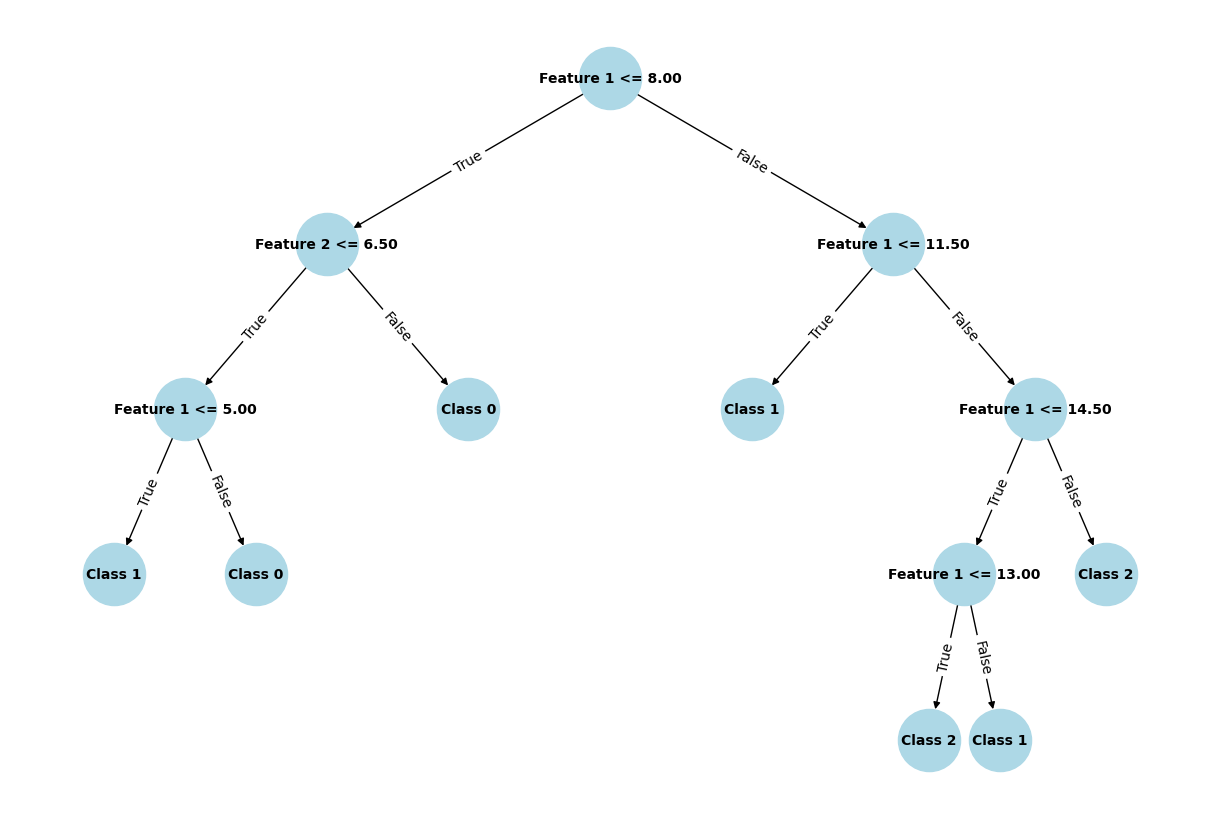

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Sample dataset with 2 features and 3 classes
X = [
    [5, 3],   # Feature set 1
    [6, 3],   # Feature set 2
    [15, 18], # Feature set 3
    [7, 7],   # Feature set 4
    [4, 6],   # Feature set 5
    [12, 5],  # Feature set 6
    [9, 3],   # Feature set 7
    [11, 4],  # Feature set 8
    [2, 9],   # Feature set 9
    [6, 1],   # Feature set 10
    [14, 10], # Feature set 11
    [18, 19], # Feature set 12
    [15, 11], # Feature set 13
    [3, 12],  # Feature set 14
]

# Multi-class labels (0, 1, 2)
y = [
    0, 0, 2, 0, 1, 
    2, 1, 1, 0, 2, 
    1, 2, 2, 0,
]

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Function to plot the decision tree using networkx, arranging by depth
def plot_tree_graph(clf, feature_names, class_names):
    tree = clf.tree_
    graph = nx.DiGraph()

    def add_node_edges(graph, node_id, depth=0, pos=None, width=1.0, vert_gap=0.2, xcenter=0.5):
        if pos is None:
            pos = {}
        if tree.feature[node_id] != -2:  # Not a leaf node
            # Add the decision node with the feature and threshold
            name = f'{feature_names[tree.feature[node_id]]} <= {tree.threshold[node_id]:.2f}'
            graph.add_node(node_id, label=name)

            # Position the node at the depth (y-coordinate) and assign x position
            pos[node_id] = (xcenter, -depth * vert_gap)

            # Add the left and right children
            left_child = tree.children_left[node_id]
            right_child = tree.children_right[node_id]
            next_width = width / 2
            graph.add_edge(node_id, left_child, label='True')
            graph.add_edge(node_id, right_child, label='False')

            # Recursive call to add children and their positions
            pos = add_node_edges(graph, left_child, depth+1, pos, next_width, vert_gap, xcenter - next_width)
            pos = add_node_edges(graph, right_child, depth+1, pos, next_width, vert_gap, xcenter + next_width)
        else:
            # It's a leaf node, assign class label
            value = tree.value[node_id]
            class_index = value.argmax()
            class_name = class_names[class_index]
            graph.add_node(node_id, label=f'{class_name}')
            pos[node_id] = (xcenter, -depth * vert_gap)

        return pos

    # Build the graph and position nodes
    pos = add_node_edges(graph, 0)

    # Extract labels and edge labels
    labels = nx.get_node_attributes(graph, 'label')
    edge_labels = nx.get_edge_attributes(graph, 'label')

    # Plotting the graph
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, labels=labels, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight='bold', arrows=True)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.show()

# Visualize the decision tree as a directional graph
plot_tree_graph(clf, feature_names=['Feature 1', 'Feature 2'], class_names=['Class 0', 'Class 1', 'Class 2'])

Node Literals and Conditions:
a: Feature 1 <= 8.00
b: Feature 2 <= 6.50
c: Feature 1 <= 5.00
d: Class: Class 1
e: Class: Class 0
f: Class: Class 0
g: Feature 1 <= 11.50
h: Class: Class 1
i: Feature 1 <= 14.50
j: Feature 1 <= 13.00
k: Class: Class 2
l: Class: Class 1
m: Class: Class 2

Total Leaf Nodes: 7
d: 0
e: 1
f: 2
h: 3
k: 4
l: 5
m: 6


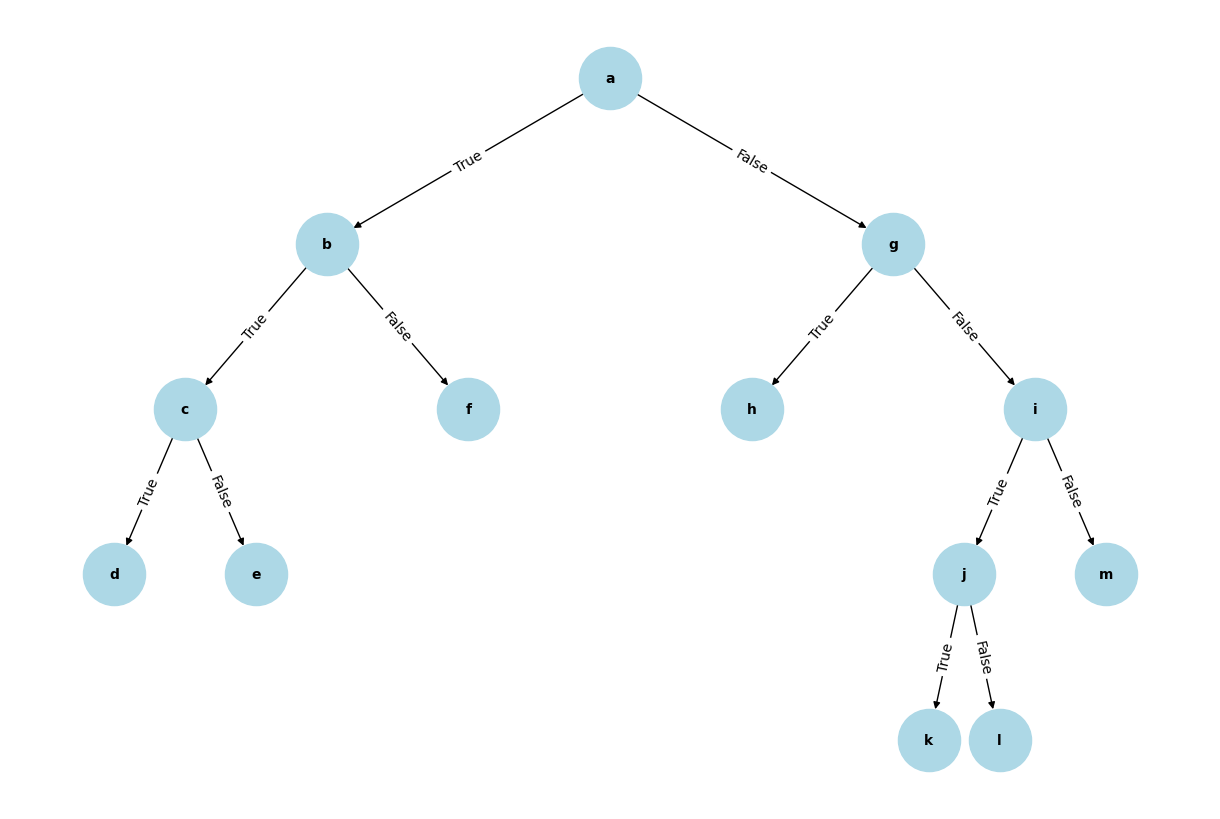

In [6]:
# Function to traverse the tree and assign literals to nodes
def traverse_tree(clf, feature_names, class_names):
    tree = clf.tree_
    literals = iter(string.ascii_lowercase)  # Generator for literals 'a', 'b', 'c', etc.
    node_literals = {}
    literal_map = {}  # To store the node_id to literal mapping
    leaf_count = 0
    leaf_nodes_map = {}
    literals_list = []

    def traverse(node_id):
        nonlocal leaf_count
        literal = next(literals)
        literal_map[node_id] = literal
        if tree.feature[node_id] != -2:  # Not a leaf node
            # Create the if statement string
            condition = f'{feature_names[tree.feature[node_id]]} <= {tree.threshold[node_id]:.2f}'
            node_literals[literal] = condition

            # Traverse the left and right children
            left_child = tree.children_left[node_id]
            right_child = tree.children_right[node_id]
            traverse(left_child)
            traverse(right_child)
            literals_list.append(literal)
        
        else:
            # It's a leaf node, assign class label
            value = tree.value[node_id]
            class_index = value.argmax()
            class_name = class_names[class_index]
            node_literals[literal] = f'Class: {class_name}'
            leaf_nodes_map[literal] = leaf_count
            leaf_count += 1

    # Start traversal from the root node (node_id = 0)
    traverse(0)

    return node_literals, literal_map, leaf_count, leaf_nodes_map, literals_list

# Function to plot the decision tree using networkx, arranging by depth, with literals as labels
def plot_tree_graph_with_literals(clf, literal_map):
    tree = clf.tree_
    graph = nx.DiGraph()

    def add_node_edges_with_literals(graph, node_id, depth=0, pos=None, width=1.0, vert_gap=0.2, xcenter=0.5):
        if pos is None:
            pos = {}
        literal = literal_map[node_id]
        if tree.feature[node_id] != -2:  # Not a leaf node
            # Add the node with the literal as label
            graph.add_node(node_id, label=literal)

            # Position the node at the depth (y-coordinate) and assign x position
            pos[node_id] = (xcenter, -depth * vert_gap)

            # Add the left and right children
            left_child = tree.children_left[node_id]
            right_child = tree.children_right[node_id]
            next_width = width / 2
            graph.add_edge(node_id, left_child, label='True')
            graph.add_edge(node_id, right_child, label='False')

            # Recursive call to add children and their positions with literals
            pos = add_node_edges_with_literals(graph, left_child, depth+1, pos, next_width, vert_gap, xcenter - next_width)
            pos = add_node_edges_with_literals(graph, right_child, depth+1, pos, next_width, vert_gap, xcenter + next_width)
        else:
            # It's a leaf node, assign class label with literal
            graph.add_node(node_id, label=literal)
            pos[node_id] = (xcenter, -depth * vert_gap)

        return pos

    # Start the traversal and assign positions with literals
    pos = add_node_edges_with_literals(graph, 0)

    # Extract labels and edge labels
    labels = nx.get_node_attributes(graph, 'label')
    edge_labels = nx.get_edge_attributes(graph, 'label')

    # Plotting the graph
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, labels=labels, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight='bold', arrows=True)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.show()

# Traverse the tree and assign literals
node_literals, literal_map, total_leaf_nodes, leaf_nodes_map, literals_list = traverse_tree(clf, feature_names=['Feature 1', 'Feature 2'], class_names=['Class 0', 'Class 1', 'Class 2'])

# Print the results
print("Node Literals and Conditions:")
for literal, condition in node_literals.items():
    print(f"{literal}: {condition}")

print(f"\nTotal Leaf Nodes: {total_leaf_nodes}")
for literal, condition in leaf_nodes_map.items():
    print(f"{literal}: {condition}")

literals_list.sort()

# Visualize the decision tree as a directional graph with literals
plot_tree_graph_with_literals(clf, literal_map)

In [7]:
import pandas as pd
import itertools

# Function to generate the truth table
def generate_truth_table(literals):
    # Generate all possible combinations of truth values (0, 1) for the literals
    truth_values = list(itertools.product([0, 1], repeat=len(literals)))
    
    # Create a DataFrame to hold the truth table
    truth_table = pd.DataFrame(truth_values, columns=literals)
    
    # Add a placeholder column 'O' for the output
    truth_table['O'] = None
    
    return truth_table

# Function to traverse the decision tree based on the truth table and update the output column
def update_truth_table_with_tree_output(clf, truth_table, literal_map):
    tree = clf.tree_
    output_column = []

    # Traverse the tree for each row in the truth table
    for _, row in truth_table.iterrows():
        node_id = 0  # Start at the root node
        
        while tree.feature[node_id] != -2:  # While it's not a leaf node
            # Get the corresponding literal for the node
            literal = literal_map[node_id]
            
            # Move to the left or right child based on the literal's value in the row
            if row[literal] == 1:  # If true, move to the right child
                node_id = tree.children_right[node_id]
            else:  # If false, move to the left child
                node_id = tree.children_left[node_id]
        
        # Reached a leaf node, get the predicted class
        value = tree.value[node_id]
        class_index = value.argmax()
        output_column.append(leaf_nodes_map[literal_map[node_id]])  # Store the class in the output column

    # Update the truth table's 'O' column with the output values
    truth_table['O'] = output_column


# Assume clf is your trained DecisionTreeClassifier, and literal_map is generated as described earlier
truth_table = generate_truth_table(literals_list)

# Update the truth table with the output from the decision tree traversal
update_truth_table_with_tree_output(clf, truth_table, literal_map)

# Print the updated truth table
# print(truth_table)

def convert_output_to_binary(truth_table, output_column_name='O', num_output_columns=3):
    # Convert the integer output to binary format
    max_bits = num_output_columns  # Number of output columns required (i.e., number of bits)
    truth_table[output_column_name] = truth_table[output_column_name].apply(lambda x: format(x, f'0{max_bits}b'))
    
    # Split the binary strings into separate columns
    binary_columns = truth_table[output_column_name].apply(lambda x: pd.Series(list(x), index=[f'{output_column_name}_{i+1}' for i in range(max_bits)]))
    
    # Drop the original output column
    truth_table = truth_table.drop(columns=[output_column_name])
    
    # Concatenate the original truth table with the new binary columns
    truth_table = pd.concat([truth_table, binary_columns], axis=1)
    
    return truth_table

# Convert the output column to binary and split into multiple columns
final_truth_table = convert_output_to_binary(truth_table, output_column_name='O', num_output_columns=3)

# Print the updated truth table
print(final_truth_table)

    a  b  c  g  i  j O_1 O_2 O_3
0   0  0  0  0  0  0   0   0   0
1   0  0  0  0  0  1   0   0   0
2   0  0  0  0  1  0   0   0   0
3   0  0  0  0  1  1   0   0   0
4   0  0  0  1  0  0   0   0   0
.. .. .. .. .. .. ..  ..  ..  ..
59  1  1  1  0  1  1   0   1   1
60  1  1  1  1  0  0   1   0   0
61  1  1  1  1  0  1   1   0   1
62  1  1  1  1  1  0   1   1   0
63  1  1  1  1  1  1   1   1   0

[64 rows x 9 columns]


In [8]:
import numpy as np
import pandas as pd
import itertools

# Function to detect the output columns
def detect_output_columns(truth_table):
    return [col for col in truth_table.columns if col.startswith('O_')]

# Function to create K-map for a given output column and input variables
def create_k_map(truth_table, input_vars, output_var):
    num_vars = len(input_vars)
    if num_vars > 4:
        raise ValueError("K-map visualization typically supports up to 4 variables.")
    
    k_map_shape = (2 ** (num_vars // 2), 2 ** (num_vars - num_vars // 2))
    k_map = np.full(k_map_shape, -1, dtype=int)  # Initialize K-map with -1 (undefined state)

    for _, row in truth_table.iterrows():
        indices = [int(row[var]) for var in input_vars]
        binary_idx = ''.join(str(i) for i in indices)
        row_idx, col_idx = map(int, np.unravel_index(int(binary_idx, 2), k_map_shape))
        k_map[row_idx, col_idx] = int(row[output_var])
    
    return k_map

# Function to simplify the K-map and generate a Boolean expression
def simplify_k_map(k_map, input_vars):
    terms = []

    rows, cols = k_map.shape
    for r in range(rows):
        for c in range(cols):
            if k_map[r, c] == 1:
                term = []
                binary_rc = f'{r:0{len(input_vars)//2}b}{c:0{len(input_vars)-len(input_vars)//2}b}'
                for i, var in enumerate(input_vars):
                    if binary_rc[i] == '0':
                        term.append(f'!{var}')
                    else:
                        term.append(f'{var}')
                terms.append("".join(term))
    
    simplified_expression = ' + '.join(terms)
    return simplified_expression

# Function to generate K-maps and the most simplified Boolean expressions for all output columns
def generate_best_boolean_expressions(truth_table):
    input_vars = [col for col in truth_table.columns if not col.startswith('O_')]
    output_columns = detect_output_columns(truth_table)
    
    best_expressions = {}
    
    if len(input_vars) <= 4:
        # If 4 or fewer variables, generate K-maps directly
        for output_var in output_columns:
            print(f"Generating K-map for {output_var}...")
            k_map = create_k_map(truth_table, input_vars, output_var)
            simplified_expression = simplify_k_map(k_map, input_vars)
            best_expressions[output_var] = simplified_expression
            print(f"Simplified Boolean expression for {output_var}: {simplified_expression}\n")
    else:
        # If more than 4 variables, iteratively reduce the input variables
        input_var_combinations = list(itertools.combinations(input_vars, 4))  # Split into combinations of 4 variables
        
        for output_var in output_columns:
            print(f"Attempting to find best Boolean expression for {output_var}...")
            best_expression = None
            for var_set in input_var_combinations:
                k_map = create_k_map(truth_table, var_set, output_var)
                simplified_expression = simplify_k_map(k_map, var_set)
                if best_expression is None or len(simplified_expression) < len(best_expression):
                    best_expression = simplified_expression
                # Stop early if we find a sufficiently simplified expression
                if len(simplified_expression) <= 4: 
                    break
            best_expressions[output_var] = best_expression
            print(f"Best simplified Boolean expression for {output_var}: {best_expression}\n")
    
    return best_expressions

# Assuming final_truth_table is your processed truth table
try:
    best_expressions = generate_best_boolean_expressions(final_truth_table)
except ValueError as e:
    print(e)

Attempting to find best Boolean expression for O_1...
Best simplified Boolean expression for O_1: a!b!cg + a!bcg + ab!cg + abcg

Attempting to find best Boolean expression for O_2...
Best simplified Boolean expression for O_2: !ab!c!i + !ab!ci + !abc!i + !abci + a!b!ci + a!bci + ab!ci + abci

Attempting to find best Boolean expression for O_3...
Best simplified Boolean expression for O_3: a!c!ij + ac!ij



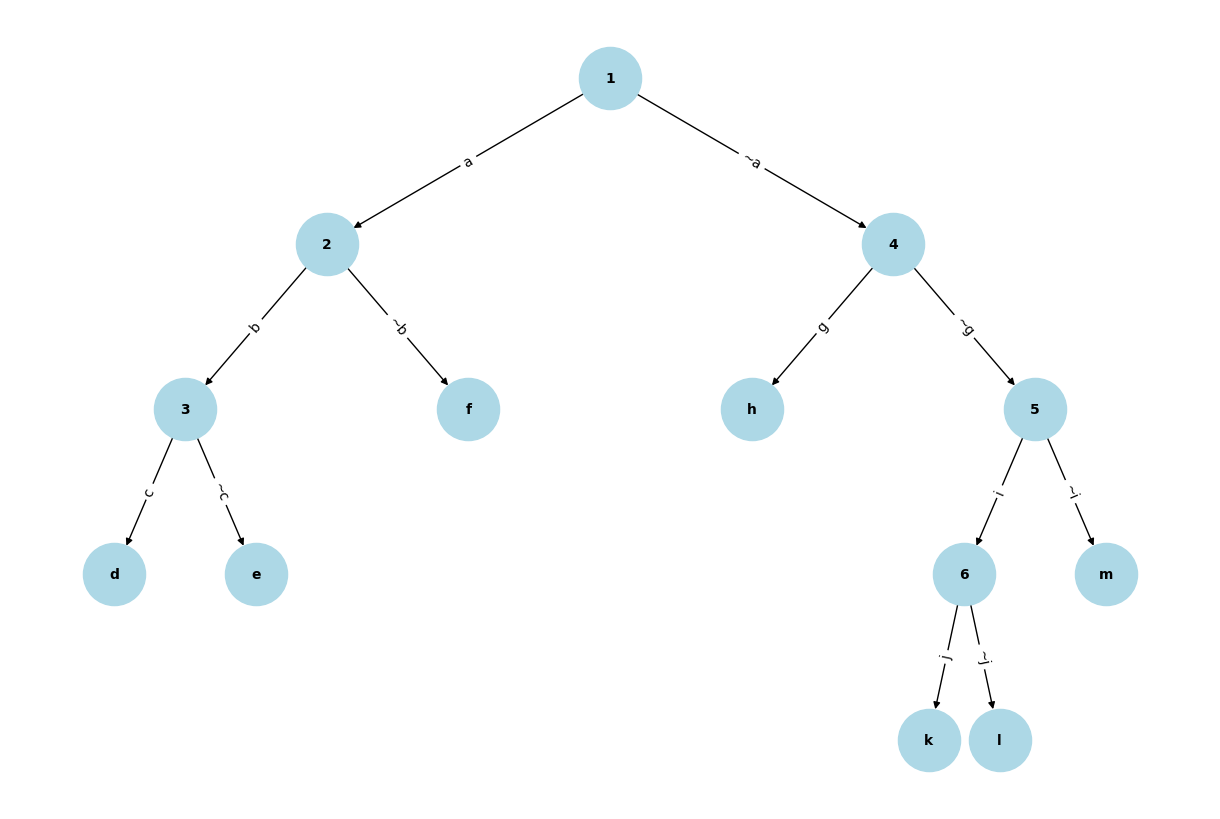

In [9]:
# Function to plot the decision tree using networkx, arranging by depth, with literals as labels
def plot_tree_graph_with_literals_BDD(clf, literal_map):
    tree = clf.tree_
    new_graph = nx.DiGraph()
    U1count=1

    def add_node_edges_with_literals(new_graph, node_id, depth=0, pos=None, width=1.0, vert_gap=0.2, xcenter=0.5):
        nonlocal U1count
        if pos is None:
            pos = {}
        literal = literal_map[node_id]
        if tree.feature[node_id] != -2:  # Not a leaf node
            # Add the node with the literal as label
            # new_graph.add_node(node_id, label=literal)
            new_graph.add_node(node_id, label=str(U1count))
            U1count=U1count+1

            # Position the node at the depth (y-coordinate) and assign x position
            pos[node_id] = (xcenter, -depth * vert_gap)

            # Add the left and right children
            left_child = tree.children_left[node_id]
            right_child = tree.children_right[node_id]
            next_width = width / 2
            new_graph.add_edge(node_id, left_child, label=f'{literal}')
            new_graph.add_edge(node_id, right_child, label=f'~{literal}')

            # Recursive call to add children and their positions with literals
            pos = add_node_edges_with_literals(new_graph, left_child, depth+1, pos, next_width, vert_gap, xcenter - next_width)
            pos = add_node_edges_with_literals(new_graph, right_child, depth+1, pos, next_width, vert_gap, xcenter + next_width)
        else:
            # It's a leaf node, assign class label with literal
            new_graph.add_node(node_id, label=literal)
            pos[node_id] = (xcenter, -depth * vert_gap)

        return pos

    # Start the traversal and assign positions with literals
    pos = add_node_edges_with_literals(new_graph, 0)

    # Extract labels and edge labels
    labels = nx.get_node_attributes(new_graph, 'label')
    edge_labels = nx.get_edge_attributes(new_graph, 'label')

    # Plotting the graph
    plt.figure(figsize=(12, 8))
    nx.draw(new_graph, pos, labels=labels, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight='bold', arrows=True)
    nx.draw_networkx_edge_labels(new_graph, pos, edge_labels=edge_labels)
    plt.show()

plot_tree_graph_with_literals_BDD(clf, literal_map)

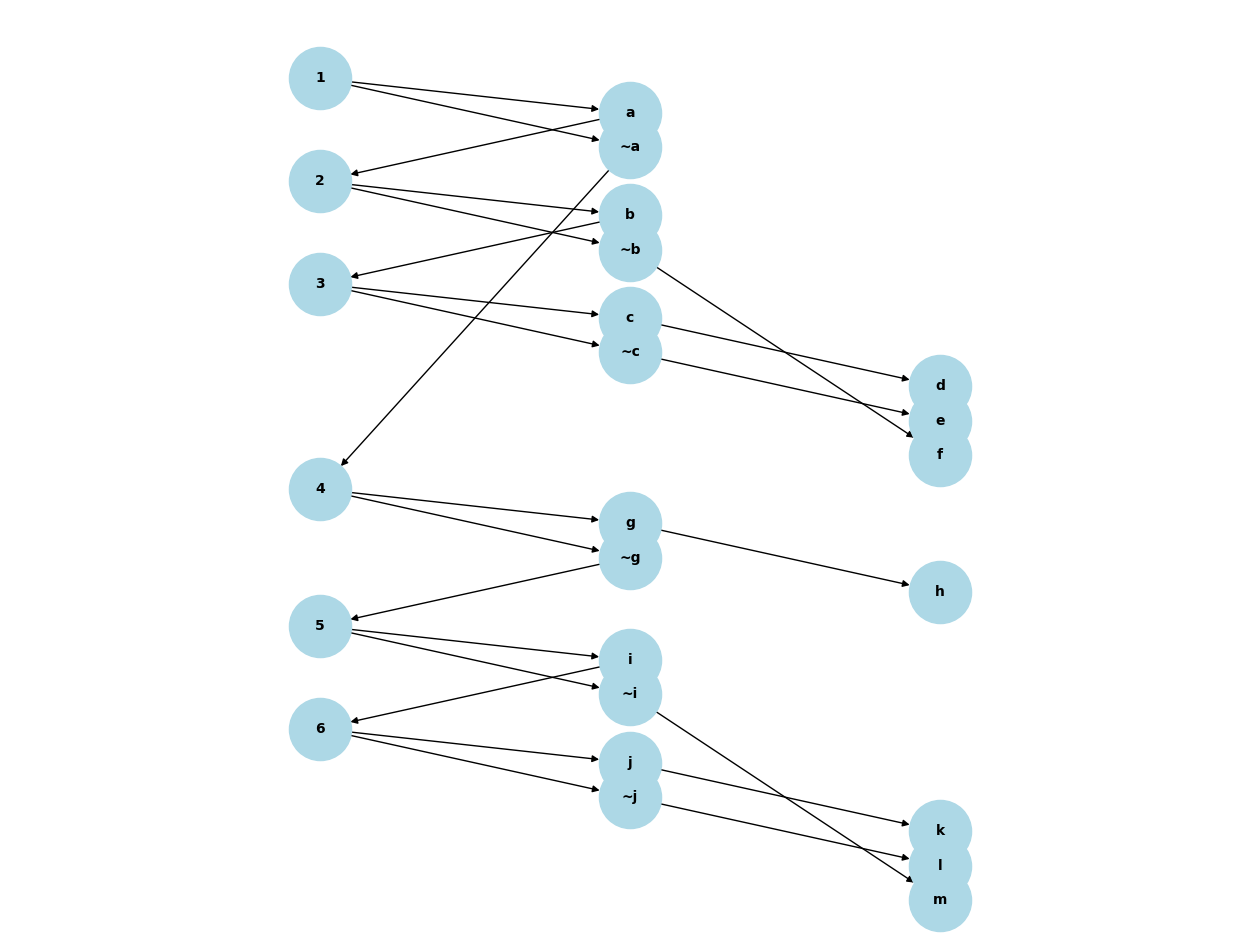

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

def transform_graph_with_edges_as_nodes(clf, literal_map):
    tree = clf.tree_
    transformed_graph = nx.DiGraph()
    U1count = 1
    L1count = 1
    edge_node_count = 1
    vert_gap=2.0

    def add_node_edges_with_transformation(graph, node_id, depth=0, pos=None, width=1.0, vert_gap=2.0, xcenter=0.5):
        nonlocal U1count, L1count, edge_node_count
        if pos is None:
            pos = {}
        literal = literal_map[node_id]

        if tree.feature[node_id] != -2:  # Not a leaf node
            # Add the original node to the graph with a numerical label
            graph.add_node(f'U{U1count}', label=str(U1count))
            original_node_label = f'U{U1count}'
            U1count += 1

            # Create new nodes for edges and connect them
            left_child = tree.children_left[node_id]
            right_child = tree.children_right[node_id]
            next_width = width / 2

            # Introduce a new node for each edge
            left_edge_node = f'E{edge_node_count}'
            right_edge_node = f'E{edge_node_count + 1}'
            edge_node_count += 2

            graph.add_node(left_edge_node, label=f'{literal}')
            graph.add_node(right_edge_node, label=f'~{literal}')

            # Recursively add the left and right children
            left_pos = add_node_edges_with_transformation(graph, left_child, depth + 1, pos, next_width, vert_gap, xcenter - next_width)
            right_pos = add_node_edges_with_transformation(graph, right_child, depth + 1, pos, next_width, vert_gap, xcenter + next_width)
            
            # Connect the nodes through the new edge nodes
            graph.add_edge(original_node_label, left_edge_node)  # From current node to left edge node
            graph.add_edge(left_edge_node, left_pos)  # Left edge node to left child

            graph.add_edge(original_node_label, right_edge_node)  # From current node to right edge node
            graph.add_edge(right_edge_node, right_pos)  # Right edge node to right child
            
            return original_node_label

        else:
            # It's a leaf node, label as L and return
            leaf_label = f'L{L1count}'
            graph.add_node(leaf_label, label=literal_map[node_id])
            L1count += 1
            return leaf_label

    # Start the transformation
    add_node_edges_with_transformation(transformed_graph, 0, vert_gap=vert_gap)

    # Define positions for nodes: original nodes on the left, edge nodes in the middle, leaves on the right
    pos = {}
    max_depth = max(depth for depth in range(tree.max_depth + 1))
    left_column_x = -1
    middle_column_x = 0
    right_column_x = 1
    bottom_y = -max_depth - 2  # Positioning leaves at the bottom
    vert_gap=1
    
    for i, node in enumerate(transformed_graph.nodes):
        if node.startswith('U'):
            pos[node] = (left_column_x, -i * vert_gap)  # Original nodes on the left
            # print("u",pos[node])
        elif node.startswith('E'):
            pos[node] = (middle_column_x, -i * vert_gap)  # Edge nodes in the middle
            # print("e",pos[node])
        elif node.startswith('L'):
            pos[node] = (right_column_x, -i * vert_gap)  # Leaf nodes on the right
            # print("l",pos[node])

    # Extract labels for visualization
    labels = nx.get_node_attributes(transformed_graph, 'label')
    edge_labels = nx.get_edge_attributes(transformed_graph, 'label')

    # Plotting the transformed graph
    plt.figure(figsize=(16, 12))
    plt.xlim(-2, 2)  # Adjust the horizontal spread
    plt.ylim(-25, 2)  # Adjust the vertical spread based on your output range
    nx.draw(transformed_graph, pos, labels=labels, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight='bold', arrows=True)
    nx.draw_networkx_edge_labels(transformed_graph, pos, edge_labels=edge_labels)
    plt.show()

# Use the function to transform and plot the graph
transform_graph_with_edges_as_nodes(clf, literal_map)
